# MNE : Demo of multivariate statistics (decoding / MVPA)

Author : Alexandre Gramfort

In [1]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [4]:
# raw_fname = '/Users/fraimondo/data/mne/sample_audvis_filt-0-40_raw.fif'
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

Read data from file:

In [37]:
raw = mne.io.Raw(raw_fname, preload=True)
raw.info['bads'] += ['EEG 053']  # we know EEG 053 is bad
print raw

<RawFIF  |  n_channels x n_times : 376 x 41700>


High pass the data above 1Hz

In [38]:
raw.filter(1, None)

In [39]:
print raw.info

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/den.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 1.0
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    exper

## Define and read epochs

First extract events:

In [40]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found
Events id: [ 1  2  3  4  5 32]


Look at the design in a graphical way:

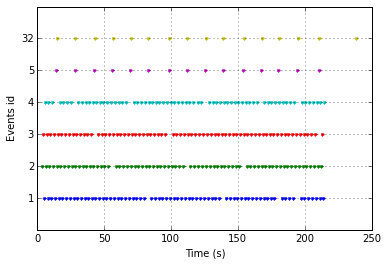

In [41]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);

## From raw to epochs

Define epochs parameters:

In [130]:
event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
tmin = -0.1  # start of each epoch
tmax = 0.4  # end of each epoch
baseline = None  # no baseline as data were high passed

reject = dict(eeg=80e-6, eog=40e-6)

picks = mne.pick_types(raw.info, eeg=True, meg=False,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # with preload

print epochs


<Epochs  |  n_events : 110 (all good), tmin : -0.1 (s), tmax : 0.4 (s), baseline : None,
 'aud_l': 54, 'aud_r': 56>


Look at the ERF and contrast between left and rigth response

In [131]:
evoked_left = epochs['aud_l'].average()
evoked_right = epochs['aud_r'].average()
evoked_contrast = evoked_left - evoked_right

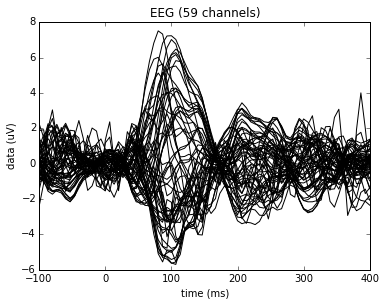

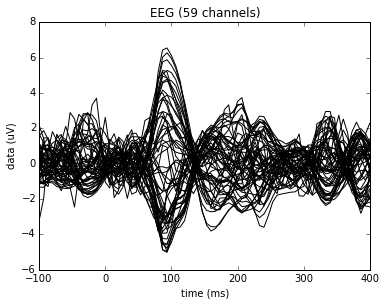

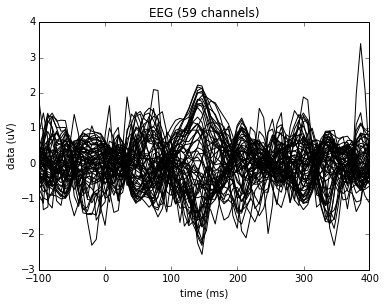

In [132]:
fig = evoked_left.plot()
fig = evoked_right.plot()
fig = evoked_contrast.plot()

Plot some topographies

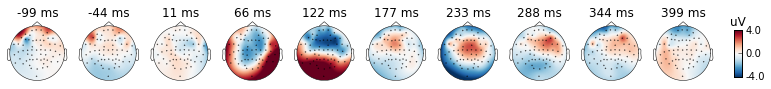

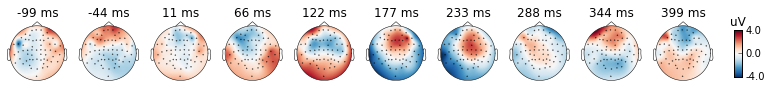

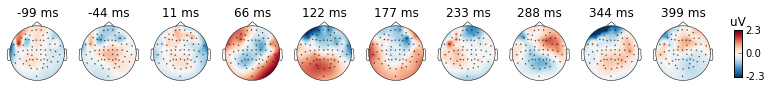

In [139]:
vmin, vmax = -4, 4
fig = evoked_left.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_right.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_contrast.plot_topomap(ch_type='eeg', contours=0, vmin=None, vmax=None)

## Now let's see if we can classify single trials with an SVM

To have a chance at 50% accuracy equalize epoch count in each condition

In [140]:
epochs.equalize_event_counts(event_id, copy=False)
print epochs


<Epochs  |  n_events : 108 (all good), tmin : -0.1 (s), tmax : 0.4 (s), baseline : None,
 'aud_l': 54, 'aud_r': 54>


A classifier takes as input an `x` and return `y` (0 or 1). Here x will be the data at one time point on all gradiometers (hence the term multivariate). We work with all sensors jointly and try to find a discriminative pattern between 2 conditions to predict the class.

For classification we will use the scikit-learn package (http://scikit-learn.org/) and MNE functions 

`
Reference:
Scikit-learn: Machine Learning in Python,
Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
`

In [141]:
from mne.decoding import TimeDecoding
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold

# make response vector
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] == 2] = 1

cv = StratifiedKFold(y=y) # do a stratified cross-validation
td = TimeDecoding(cv=cv, scorer=roc_auc_score, n_jobs=1)


maximum AUC score: 0.796296296296


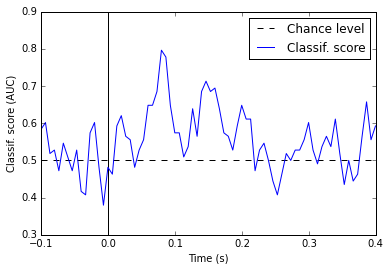

In [145]:
# Fit, score, and plot

td.fit(epochs, y=y)
scores = td.score(epochs)
print 'maximum AUC score:', max(scores)
td.plot(ymin=0.3, ymax=0.9);

## Look at generalization over time

We can test how much the "decodability" stays over time.

Have a look at :

http://martinos.org/mne/dev/auto_examples/decoding/plot_decoding_time_generalization.html

to get an idea of what to expect.

In [149]:
from mne.decoding import GeneralizationAcrossTime

gat = GeneralizationAcrossTime(predict_mode='cross-validation', n_jobs=2, cv=cv, scorer=roc_auc_score)

# fit and score
gat.fit(epochs, y=y)
gat.score(epochs);

Now visualize

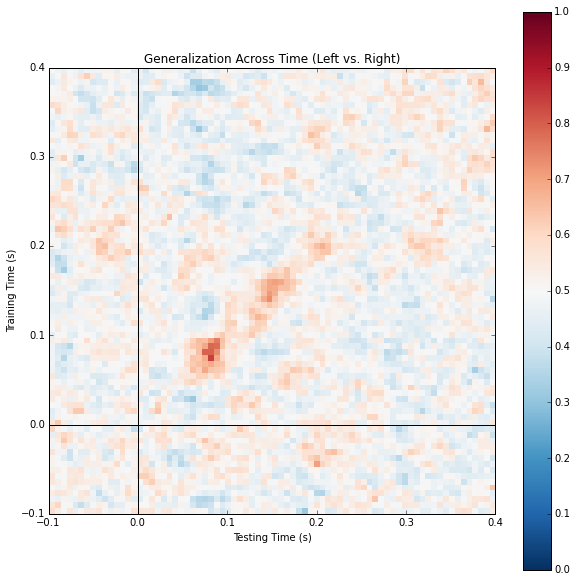

In [150]:
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=300)
gat.plot(vmin=0, vmax=1, ax=ax,
         title="Generalization Across Time (Left vs. Right)");

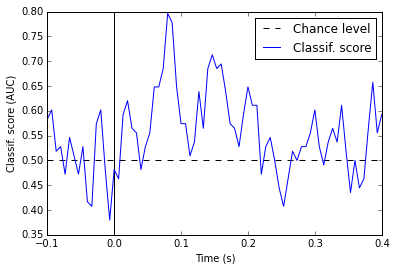

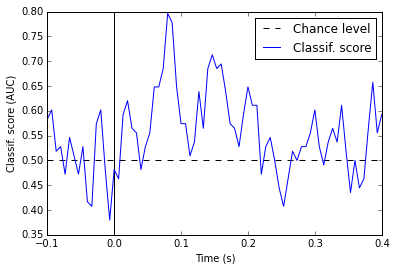

In [151]:
gat.plot_diagonal();  # again our diagonal. Remember?

## Exercise

- Can you improve the performance using full epochs and a common spatial pattern (CSP) used by most BCI systems?
- explore other datasets from MNE

Have a look at the example

http://martinos.org/mne/dev/auto_examples/decoding/plot_decoding_csp_space.html